LDA Accuracy = 0.97
QDA Accuracy = 0.96


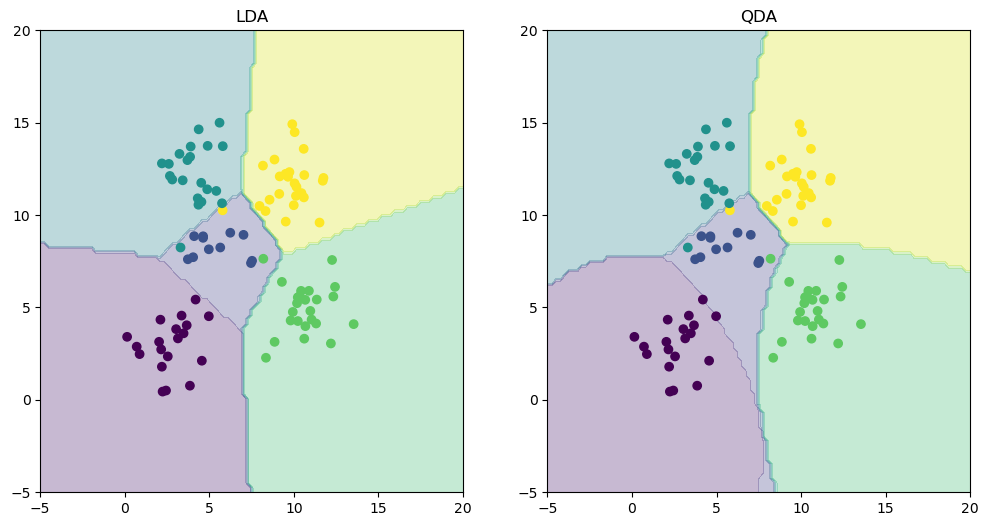

MSE without intercept 106775.36145502607
MSE with intercept 3707.840180416822
L2 Norm for test data in Linear Regression: 15508100894.620695
Optimal lambda: 0.06


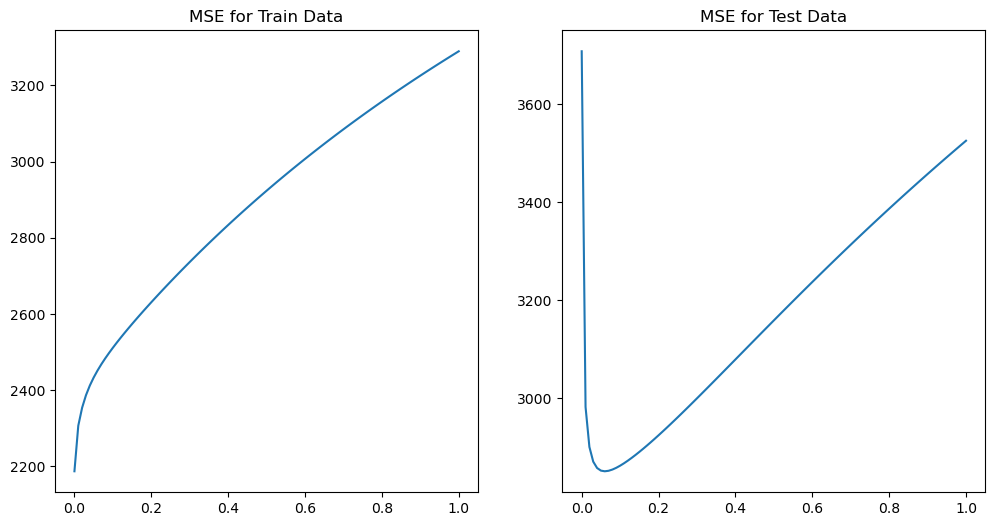

L2 Norm for test data in Ridge Regression: 185010.691292986
Gradient Descent MSE for Train Data (optimal lambda): [2448.82704127]
Gradient Descent MSE for Test Data (optimal lambda): [2833.85711219]


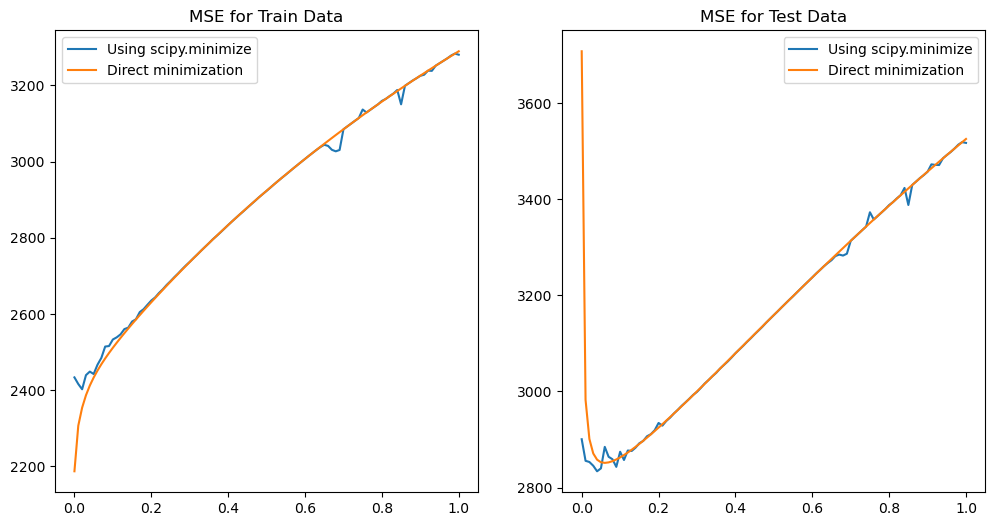

Optimal polynomial degree with no regularization: 1
Optimal polynomial degree with regularization: 4


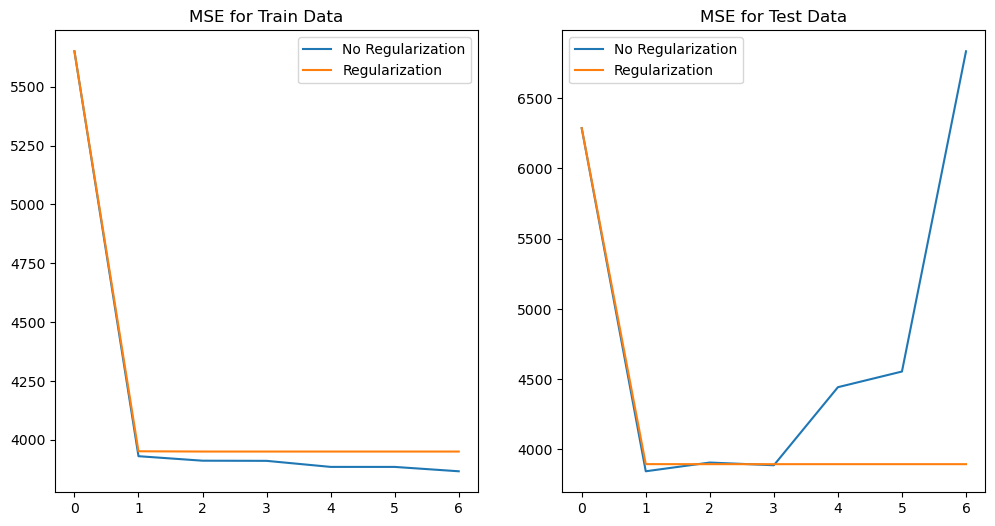

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys
import pandas as pd

def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix
    n_features = X.shape[1]
    unique_classes = np.unique(y)
    n_classes = unique_classes.size

    means = np.array([
        X[y.flatten() == cls].mean(axis=0)
        for cls in unique_classes
    ]).T

    covmat = np.cov(X.T, bias=True)
    return means, covmat


def qdaLearn(X, y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    unique_classes = np.unique(y)
    n_features = X.shape[1]
    n_classes = unique_classes.size

    means = np.zeros((n_features, n_classes))
    covmats = []

    class_idx = 0  
    for class_val in unique_classes:
        class_subset = X[y.flatten() == class_val]
        means[:, class_idx] = class_subset.mean(axis=0)
        covmats.append(np.cov(class_subset.T, bias=True))
        class_idx += 1  

    return means, covmats



def ldaTest(means, covmat, Xtest, ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels
    covariance_inverse = inv(covmat)
    linear_combination = np.dot(Xtest, covariance_inverse @ means) - 0.5 * np.sum(means * (covariance_inverse @ means), axis=0)
    ypred = (linear_combination.argmax(axis=1) + 1)
    acc = (ypred == ytest.flatten()).mean()
    return acc, ypred


def qdaTest(means, covmats, Xtest, ytest):
    # Inputs:
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs:
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels
    num_classes = len(means[0]) 
    class_scores = np.zeros((Xtest.shape[0], num_classes))

    for i, class_mean in enumerate(means.T): 
        class_cov_inv = inv(covmats[i])
        class_cov_det = det(covmats[i])
        diff_matrix = Xtest - class_mean.T
        class_scores[:, i] = -0.5 * np.sum(diff_matrix @ class_cov_inv * diff_matrix, axis=1) - \
                             0.5 * np.log(class_cov_det)

    ypred = np.argmax(class_scores, axis=1) + 1
    acc = np.mean(ypred == ytest.flatten())
    return acc, ypred


def learnOLERegression(X, y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1
    
    X_transpose = np.transpose(X)
    X_transpose_X = np.dot(X_transpose, X)
    X_transpose_y = np.dot(X_transpose, y)
    w = np.dot(np.linalg.inv(X_transpose_X), X_transpose_y)
    return w


def learnRidgeRegression(X, y, lambd):
    # Inputs:
    # X = N x d
    # y = N x 1
    # lambd = ridge parameter (scalar)
    # Output:
    # w = d x 1

    X_transpose_X = np.dot(X.T, X)
    lambda_identity = lambd * np.identity(X.shape[1])
    matrix = lambda_identity + X_transpose_X
    inverse_matrix = np.linalg.inv(matrix)
    w = np.dot(inverse_matrix, np.dot(X.T, y))
    return w

def testOLERegression(w, Xtest, ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    residuals = ytest - np.dot(Xtest, w)
    mse = np.mean(np.square(residuals))
    return mse

def regressionObjVal(w, X, y, lambd):
    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda

    w_reshaped = np.reshape(w, (w.size, 1))
    error = (np.sum(np.square(y - np.dot(X, w_reshaped)) / 2)) + ((lambd * np.dot(w_reshaped.T, w_reshaped)) / 2)
    error_grad = (-1.0 * np.dot(y.T, X)) + np.dot(np.dot(w_reshaped.T, X.T), X) + (lambd * w_reshaped.T)
    return error.flatten(), error_grad.flatten()


def mapNonLinear(x, p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xp - (N x (p+1))

    Xp = np.ones((x.shape[0], 1))
    x = np.reshape(x, (x.shape[0], 1))
    for power in range(1, p + 1):
        term = np.array(x ** power)
        Xp = np.concatenate((Xp, term), axis=1)
    return Xp

# L2Norm for weight comparision
def L2Norm(weight):
    l2_norm = np.sum(np.square(weight))
    return l2_norm

# Main script

# Problem 1
# load the sample data
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
plt.title('QDA')

plt.show()

# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

print('L2 Norm for test data in Linear Regression:',L2Norm(w_i))

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    #Used for report
    #print(f"{lambd:.2f}   {mses3_train[i][0]:.4f}   {mses3[i][0]:.4f}")
    i = i + 1

# Optimal lambda on the basis of test data
Optimal_lambda = lambdas[np.argmin(mses3)]
print('Optimal lambda: {}'.format(Optimal_lambda))

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

print('L2 Norm for test data in Ridge Regression:',L2Norm(w_l))
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.
w_init = np.ones((X_i.shape[1], 1)).flatten()
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    #Used for report
    #print(f"{lambd:.2f}   {mses4_train[i][0]:.4f}   {mses4[i][0]:.4f}")
    i = i + 1

print('Gradient Descent MSE for Train Data (optimal lambda): {}'.format(mses4_train[np.argmin(mses4)]))
print('Gradient Descent MSE for Test Data (optimal lambda): {}'.format(mses4[np.argmin(mses4)]))



fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()


# Problem 5
pmax = 7
lambda_opt = 0.06 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
#Used for report
#print(f"{'p'} {'Training Data'} {'Testing Data'}")
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    #Used for report
    #print(f"{p}   {mses5_train[p,0]:.4f}   {mses5[p,0]:.4f}")
    
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)
    #Used for report
    #print(f"{p}   {mses5_train[p,1]:.4f}   {mses5[p,1]:.4f}")


optimal_degree_no_reg = np.argmin(mses5[:, 0])
optimal_degree_with_reg = np.argmin(mses5[:, 1])
print('Optimal polynomial degree with no regularization: {}'.format(optimal_degree_no_reg))
print('Optimal polynomial degree with regularization: {}'.format(optimal_degree_with_reg))



fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()

